In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
import seaborn as sns

### Load Data

In [27]:
df1 = pd.read_csv('../input/loan_2014.csv')

/home/wing/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
df1.shape

(235631, 95)

In [29]:
df1.tail()

,homeownership,totalbclimit,loanamnt,numtloppast12m,pubrecbankruptcies,taxliens,totalilhighcreditlimit,verificationstatusjoint,pcttlnvrdlq,mosinrcnttl,...,openil12m,mthssincerecentbc,numbctl,earliestcrline,ilutil,avgcurbal,percentbcgt75,term,issued,loanstatus
235626,MORTGAGE,8500.0,20700.0,0.0,0.0,0.0,83482.0,NaN,97.6,19.0,...,NaN,93.0,1.0,Dec-2001,NaN,4089.0,100.0,60 months,Jan-2014,Current
235627,OWN,47500.0,2000.0,4.0,0.0,0.0,37200.0,NaN,85.2,5.0,...,NaN,5.0,10.0,Feb-2003,NaN,28172.0,11.1,36 months,Jan-2014,Fully Paid
235628,MORTGAGE,13500.0,10000.0,2.0,0.0,0.0,65470.0,NaN,90.9,4.0,...,NaN,4.0,11.0,Feb-2000,NaN,11495.0,50.0,36 months,Jan-2014,Fully Paid
235629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df1 = df1[0:235629]

In [31]:
df1.shape

(235629, 95)

### Select feature

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235629 entries, 0 to 235628
Data columns (total 95 columns):
homeownership                 235629 non-null object
totalbclimit                  235629 non-null float64
loanamnt                      235629 non-null float64
numtloppast12m                235629 non-null float64
pubrecbankruptcies            235629 non-null float64
taxliens                      235629 non-null float64
totalilhighcreditlimit        235629 non-null float64
verificationstatusjoint       0 non-null float64
pcttlnvrdlq                   235629 non-null float64
mosinrcnttl                   235629 non-null float64
accnowdelinq                  235629 non-null float64
totalbalexmort                235629 non-null float64
id                            235629 non-null object
grade                         235629 non-null object
intrate                       235629 non-null object
tothicredlim                  235629 non-null float64
emplength                     2356

In [33]:
cols = df1.columns.values
all_null_feature = []
num_feature=[]
ob_feature=[]

for col in cols:
    if df1[col].isnull().sum() == df1.shape[0]:
        all_null_feature.append(col)
    else: #全部为null的feature不予考虑
        if df1[col].dtype == 'object':
            ob_feature.append(col)
        else:
            num_feature.append(col)

In [34]:
ob_feature

['homeownership',
 'id',
 'grade',
 'intrate',
 'emplength',
 'verificationstatus',
 'revolutil',
 'zipcode',
 'purpose',
 'addrstate',
 'subgrade',
 'emptitle',
 'applicationtype',
 'initialliststatus',
 'desc',
 'earliestcrline',
 'term',
 'issued',
 'loanstatus']

In [35]:
num_feature

['totalbclimit',
 'loanamnt',
 'numtloppast12m',
 'pubrecbankruptcies',
 'taxliens',
 'totalilhighcreditlimit',
 'pcttlnvrdlq',
 'mosinrcnttl',
 'accnowdelinq',
 'totalbalexmort',
 'tothicredlim',
 'bcutil',
 'mthssincerecentinq',
 'mortacc',
 'numrevaccts',
 'numtl120dpd2m',
 'mthssincelastdelinq',
 'mthssincelastmajorderog',
 'revolbal',
 'mosinoldrevtlop',
 'accopenpast24mths',
 'mosinoldilacct',
 'numiltl',
 'ficorangehigh',
 'totcollamt',
 'installment',
 'mosinrcntrevtlop',
 'numtl90gdpd24m',
 'inqlast6mths',
 'numactvbctl',
 'totcurbal',
 'annualinc',
 'openacc',
 'mthssincerecentbcdlq',
 'totalacc',
 'collections12mthsexmed',
 'fundedamnt',
 'totalrevhilim',
 'dti',
 'numrevtlbalgt0',
 'numoprevtl',
 'numtl30dpd',
 'delinqamnt',
 'numactvrevtl',
 'numbcsats',
 'numsats',
 'bcopentobuy',
 'ficorangelow',
 'numacctsever120pd',
 'chargeoffwithin12mths',
 'pubrec',
 'mthssincelastrecord',
 'mthssincerecentrevoldelinq',
 'delinq2yrs',
 'mthssincerecentbc',
 'numbctl',
 'avgcurbal',


In [36]:
select_feature = ob_feature + num_feature
len(select_feature)

77

#### ob_feature

In [115]:
# 可以转化为float64的：
# intrate, revolutil, 去掉'%'
# issue_d，在current_data中不存在，可用于训练数据的split，转化为月份对应的数字
# zipcode去掉后两位的'xx'，转化为数字（邮编的距离还是有一定意义的）
# loanstatus， 作为target，只取两种数据：Charged Off-->1, Fully Paid-->0
# desc内容复杂，null值较多，考虑转化为：1--填写，0--未填写
# 时间类型： earliestcrline, 通过计算，取得时间长度, 如：earliestcrline，可计算credit line有多少个月

# 细节描述： id, 考虑删除 
# 只有一个取值的： applicationtype，考虑删除

# 真正object的： homeownership, grade, emplength, verificationstatus, purpose, addrstate,
#              subgrade, emptitle, initialliststatus
# 其中，emp_title可以汇总成更少的组

In [ ]:
# 只有一个取值的： applicationtype，考虑删除

In [37]:
len(ob_feature)

19

In [38]:
ob_feature.remove('applicationtype')
#ob_feature.remove('term')

In [14]:
# remove 'id', 'issued' and 'loanstatus' from ob_feature, since they are index, train/test flag and target

In [39]:
ob_feature.remove('id')
ob_feature.remove('issued')
ob_feature.remove('loanstatus')

In [ ]:
# remove 'desc' from ob_feature
# or replace 'desc' with 1 for remarks and 0 for np.nan

In [40]:
df1['desc'].isnull().sum()

220350

In [41]:
df1['withdesc'] = df1['desc'].fillna(0)

In [42]:
df1['withdesc'] = df1['withdesc'].apply(lambda x: 1 if x != 0 else 0)

In [43]:
df1['withdesc'].value_counts()

0    220350
1     15279
Name: withdesc, dtype: int64

In [44]:
ob_feature.remove('desc')

In [104]:
#ob_feature.remove('withdesc')
num_feature.append('withdesc')

In [45]:
len(ob_feature)

15

In [46]:
ob_feature

['homeownership',
 'grade',
 'intrate',
 'emplength',
 'verificationstatus',
 'revolutil',
 'zipcode',
 'purpose',
 'addrstate',
 'subgrade',
 'emptitle',
 'initialliststatus',
 'earliestcrline',
 'term',
 'withdesc']

#### num_feature

In [ ]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan

,fundedamnt,loanamnt
0,10400.0,10400.0
1,15000.0,15000.0
2,9600.0,9600.0
3,7650.0,7650.0
4,21425.0,21425.0
5,12800.0,12800.0
6,12975.0,12975.0
7,16000.0,16000.0
8,21075.0,21075.0
9,17000.0,17000.0


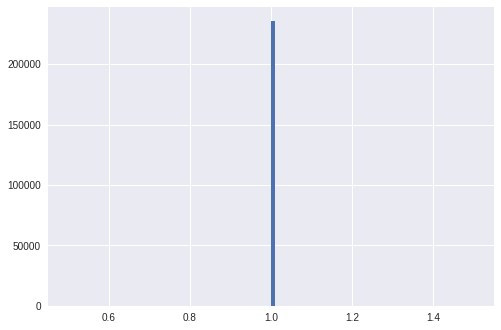

In [47]:
df1.ratio = df1.fundedamnt/df1.loanamnt.astype(float,3)
df1.ratio.hist(bins=100)
df1[['fundedamnt', 'loanamnt']][0:10]

In [48]:
num_feature.remove('fundedamnt')

In [49]:
len(num_feature)

57

In [50]:
select_feature = ob_feature + num_feature
len(select_feature)

72

In [51]:
df = df1[select_feature + ['id', 'loanstatus', 'issued']]

In [52]:
df.shape

(235629, 75)

### Select Data

#### only use loanstatus = fully_paid and charged off

In [53]:
df.loanstatus.value_counts()

Fully Paid            152324
Current                43129
Charged Off            36654
Late (31-120 days)      1728
In Grace Period         1362
Late (16-30 days)        419
Default                   13
Name: loanstatus, dtype: int64

In [54]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off'")

In [55]:
df.shape

(188978, 75)

#### only use term = 36 months

In [56]:
df1.term.value_counts()

 36 months    162570
 60 months     73059
Name: term, dtype: int64

In [57]:
df = df.query("term == ' 36 months'")

In [58]:
df.shape

(145650, 75)

In [59]:
ob_feature.remove('term')

### Label Target

In [60]:
df['loanstatus'] = df.loanstatus.map({"Charged Off":1, "Fully Paid":0})

In [63]:
df['loanstatus'].value_counts()

0    124046
1     21604
Name: loanstatus, dtype: int64

In [64]:
df['loanstatus'].value_counts(normalize = True)

0    0.851672
1    0.148328
Name: loanstatus, dtype: float64

### Out of time testing set and in-time training set (Oct-Dec as test)

In [65]:
issued = list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [66]:
df['train_flag'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df['train_flag'].value_counts()

1    111919
0     33731
Name: train_flag, dtype: int64

### Feature Engineering & Cleaning

#### Datetime to numeric feature

In [68]:
df['earliestcrline'].unique()[:5]

array(['Sep-1989', 'Nov-1992', 'Aug-2002', 'Jan-1999', 'Jan-2001'], dtype=object)

In [ ]:
# convert to number of months to Dec 2014

In [70]:
c1_month = df['earliestcrline'].apply(lambda x: x.split('-')[0])
c1_year = df['earliestcrline'].apply(lambda x: int(x.split('-')[1]))

In [71]:
c1_month.unique()

array(['Sep', 'Nov', 'Aug', 'Jan', 'Jul', 'Oct', 'May', 'Dec', 'Jun',
       'Apr', 'Mar', 'Feb'], dtype=object)

In [72]:
c1_year.unique()

array([1989, 1992, 2002, 1999, 2001, 2003, 1998, 2009, 1993, 1996, 1995,
       2007, 1988, 2004, 1994, 2008, 2006, 1997, 2010, 2000, 2011, 1986,
       1973, 2005, 1987, 1985, 1982, 1991, 1984, 1976, 1990, 1978, 1974,
       1981, 1977, 1979, 1983, 1971, 1967, 1980, 1972, 1968, 1962, 1965,
       1966, 1975, 1963, 1969, 1970, 1964, 1958, 1959, 1955, 1961, 1960,
       1954, 1957, 1949, 1950, 1948, 1953, 1956])

In [73]:
dict_month = {'Jan':11, 'Feb':10, 'Mar':9, 'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [76]:
df['earliestcrline_m'] = df['earliestcrline'].apply(lambda x: (2014-int(x.split('-')[1]))*12 + dict_month[x.split('-')[0]])

In [77]:
df['earliestcrline_m'][:5]

0    303
2    265
3    148
6    191
9    167
Name: earliestcrline_m, dtype: int64

In [78]:
num_feature.append('earliestcrline_m')
ob_feature.remove('earliestcrline')

In [79]:
print(len(ob_feature), len(num_feature))

13 58


#### emplength to numeric feature

In [80]:
df['emplength'].isnull().sum()

0

In [81]:
df['emplength'].unique()

array(['8 years', '10+ years', '< 1 year', '2 years', '7 years', '9 years',
       'n/a', '4 years', '3 years', '1 year', '5 years', '6 years'], dtype=object)

In [82]:
df['emplength'].replace('n/a', np.nan, inplace = True)

In [83]:
df['emplength'].replace('< 1 year', 0, inplace = True)
df['emplength'].replace(to_replace = '[^0-9]+', value = '', inplace = True, regex = True)
df['emplength'].fillna(value = -999, inplace = True)

In [84]:
df['emplength'] = df['emplength'].astype(int)

In [85]:
df['emplength'].value_counts()

 10     45565
 2      13198
 3      11844
 0      11777
 1       9550
 4       8579
-999     8365
 5       8291
 7       8065
 6       7485
 8       7262
 9       5669
Name: emplength, dtype: int64

In [86]:
num_feature.append('emplength')
ob_feature.remove('emplength')

NameError: name 'num_featue' is not defined

In [87]:
print (len(ob_feature), len(num_feature))

12 59


#### % to numeric feature : intrate, revolutil

In [88]:
intrate = df['intrate'].apply(lambda x: float(x.replace('%', '')))

In [89]:
df['intrate'] = intrate
df['intrate'][:2]

0     6.99
2    13.66
Name: intrate, dtype: float64

In [90]:
df['revolutil'][:3]

0    31.6%
2    59.4%
3    91.9%
Name: revolutil, dtype: object

In [91]:
revolutil = df['revolutil'].apply(lambda x: str(x).replace('%', '')).astype(float)

In [92]:
df['revolutil'] = revolutil
df['revolutil'][:2]

0    31.6
2    59.4
Name: revolutil, dtype: float64

In [93]:
ob_feature.remove('intrate')
ob_feature.remove('revolutil')

num_feature.append('intrate')
num_feature.append('revolutil')

In [94]:
print (len(ob_feature), len(num_feature))

10 61


#### Ordinal feature encoding: grade, subgrade

In [95]:
dict_grade = {"A":1,
             "B":2,
             "C":3,
             "D":4,
             "E":5,
             "F":6,
             "G":7}

In [96]:
df['grade'] = df['grade'].map(dict_grade)

In [98]:
df['subgrade'] = df['subgrade'].apply(lambda x: (dict_grade[x[0]] -1) * 5 + int(x[1]))

In [99]:
df['grade'].unique()

array([1, 3, 4, 2, 5, 6, 7])

In [100]:
df['subgrade'].unique()

array([ 3, 13, 20, 10, 14,  9, 17, 15,  8, 12, 11,  7,  5, 18, 25,  6,  4,
       21, 16,  2,  1, 22, 27, 19, 29, 23, 24, 26, 28, 31, 32, 30, 33, 34,
       35])

In [101]:
ob_feature.remove('grade')
ob_feature.remove('subgrade')

num_feature.append('grade')
num_feature.append('subgrade')

In [105]:
print (len(ob_feature), len(num_feature))

7 64


### High cardinality feature encoding

#### Zip Code -frequency encoding

In [106]:
df.zipcode.nunique()

852

In [107]:
df['zipcode'].unique()

array(['937xx', '077xx', '850xx', '331xx', '144xx', '483xx', '982xx',
       '554xx', '208xx', '852xx', '112xx', '926xx', '403xx', '463xx',
       '853xx', '567xx', '960xx', '467xx', '810xx', '114xx', '232xx',
       '130xx', '900xx', '196xx', '283xx', '324xx', '300xx', '560xx',
       '670xx', '358xx', '210xx', '076xx', '402xx', '967xx', '363xx',
       '958xx', '787xx', '629xx', '273xx', '802xx', '328xx', '750xx',
       '917xx', '410xx', '179xx', '347xx', '379xx', '800xx', '442xx',
       '574xx', '201xx', '922xx', '234xx', '620xx', '951xx', '871xx',
       '774xx', '762xx', '789xx', '223xx', '481xx', '217xx', '857xx',
       '949xx', '902xx', '971xx', '145xx', '189xx', '294xx', '571xx',
       '170xx', '975xx', '604xx', '350xx', '928xx', '494xx', '840xx',
       '088xx', '207xx', '751xx', '957xx', '953xx', '070xx', '113xx',
       '276xx', '908xx', '563xx', '123xx', '440xx', '760xx', '191xx',
       '988xx', '019xx', '939xx', '761xx', '783xx', '370xx', '735xx',
       '730xx', '919

In [111]:
df['zipcode'].unique()[:5]

array(['937xx', '077xx', '850xx', '331xx', '144xx'], dtype=object)

In [112]:
# convert zipcode to int
df['zipcode'] = df['zipcode'].apply(lambda x: int(x[0:3]))

In [113]:
df['zipcode'][:5]

0    937
2     77
3    850
6    331
9    144
Name: zipcode, dtype: int64

In [114]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [115]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,209
2,11,55
3,12,57
4,13,39


In [116]:
df['zipcode'].value_counts()

750    1599
945    1588
112    1584
606    1501
300    1297
100    1279
900    1269
331    1253
770    1222
70     1221
917    1112
891    1111
104    1088
330    1063
117    1000
921     992
852     957
913     887
926     856
925     842
113     802
334     798
600     790
481     774
601     754
604     754
956     747
941     730
853     726
928     724
       ... 
94        4
414       3
91        3
311       3
90        3
879       3
884       3
834       2
98        2
833       1
938       1
832       1
500       1
587       1
511       1
682       1
901       1
527       1
43        1
92        1
429       1
685       1
8         1
942       1
680       1
510       1
854       1
821       1
681       1
523       1
Name: zipcode, Length: 852, dtype: int64

In [117]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [118]:
df = pd.merge(df, zipcode_freq, how = 'left', on = 'zipcode')

In [119]:
df['zipcode_freq'][:5]

0     224
1     326
2     664
3    1253
4     182
Name: zipcode_freq, dtype: int64

In [120]:
ob_feature.remove('zipcode')

num_feature.append('zipcode')
num_feature.append('zipcode_freq')

In [121]:
print (len(ob_feature), len(num_feature))

6 66


#### emptitle-frequency encoding (can do some NLP for later stage)

In [122]:
emptitle_freq = df.groupby('emptitle').size().reset_index()

In [127]:
emptitle_freq[:5]

,emptitle,emptitle_freq
0,Credit rev specialist,1
1,Shipper/packer,1
2,AP Coordinator,1
3,Accounting & HR & Sales,1
4,Assistant Principal,1


In [123]:
df['emptitle'].value_counts()

Teacher                                   2800
Manager                                   2252
Registered Nurse                          1220
RN                                        1106
Supervisor                                 976
Owner                                      898
Sales                                      876
Project Manager                            799
Office Manager                             760
Driver                                     713
manager                                    702
teacher                                    637
Director                                   598
General Manager                            592
President                                  519
owner                                      517
driver                                     516
Engineer                                   491
Administrative Assistant                   476
Vice President                             448
Attorney                                   446
Accountant   

In [124]:
emptitle_freq.columns = ['emptitle', 'emptitle_freq']

In [125]:
df = pd.merge(df, emptitle_freq, how = 'left', on = 'emptitle')

In [126]:
df['emptitle_freq'][:5]

0      1.0
1      4.0
2     15.0
3    876.0
4     12.0
Name: emptitle_freq, dtype: float64

In [128]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')

In [130]:
print (len(ob_feature), len(num_feature))

5 67


#### Addr_state-feequency encoding

In [131]:
addrstate_freq = df.groupby('addrstate').size().reset_index()
addrstate_freq.columns = ['addrstate', 'addrstate_freq']
df = pd.merge(df, addrstate_freq, how='left', on='addrstate')

In [132]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')

In [133]:
print (len(ob_feature), len(num_feature))

4 68


#### One Hot Encoding

In [134]:
ob_feature

['homeownership', 'verificationstatus', 'purpose', 'initialliststatus']

In [135]:
dummy_feature = ob_feature

In [136]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [137]:
OHE_feature = list(df_dummy.columns.values)
OHE_feature

['homeownership_ANY',
 'homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'verificationstatus_Not Verified',
 'verificationstatus_Source Verified',
 'verificationstatus_Verified',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'initialliststatus_f',
 'initialliststatus_w']

In [138]:
len(OHE_feature)

22

In [139]:
df = pd.concat([df, df_dummy], axis = 1)

In [140]:
df.shape

(145650, 102)

In [141]:
select_feature = num_feature + OHE_feature
len(select_feature)

90

### XGBoost

In [142]:
feat = select_feature
print(feat)

['totalbclimit', 'loanamnt', 'numtloppast12m', 'pubrecbankruptcies', 'taxliens', 'totalilhighcreditlimit', 'pcttlnvrdlq', 'mosinrcnttl', 'accnowdelinq', 'totalbalexmort', 'tothicredlim', 'bcutil', 'mthssincerecentinq', 'mortacc', 'numrevaccts', 'numtl120dpd2m', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'revolbal', 'mosinoldrevtlop', 'accopenpast24mths', 'mosinoldilacct', 'numiltl', 'ficorangehigh', 'totcollamt', 'installment', 'mosinrcntrevtlop', 'numtl90gdpd24m', 'inqlast6mths', 'numactvbctl', 'totcurbal', 'annualinc', 'openacc', 'mthssincerecentbcdlq', 'totalacc', 'collections12mthsexmed', 'totalrevhilim', 'dti', 'numrevtlbalgt0', 'numoprevtl', 'numtl30dpd', 'delinqamnt', 'numactvrevtl', 'numbcsats', 'numsats', 'bcopentobuy', 'ficorangelow', 'numacctsever120pd', 'chargeoffwithin12mths', 'pubrec', 'mthssincelastrecord', 'mthssincerecentrevoldelinq', 'delinq2yrs', 'mthssincerecentbc', 'numbctl', 'avgcurbal', 'percentbcgt75', 'earliestcrline_m', 'emplength', 'intrate', 'revoluti

#### Preliminary manually parameter tuning based on stratified train-test split

In [144]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
# Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle = True, random_state = 2019)

In [146]:
df_train = df.query("train_flag == 1")
df_test = df.query("train_flag == 0")

In [147]:
df_train.shape

(111919, 102)

In [148]:
df_test.shape

(33731, 102)

In [149]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, test_size = 0.3,
                                                     random_state = 2014, stratify = df_train.loanstatus)

In [150]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [151]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [152]:
params = {"objective": "binary:logistic",
         "booster": "gbtree",
         "eta": 0.05,
         "max_depth": 6,
         "subsample": 0.632,
         "colsample_bytree": 0.7,
         #"colsample_bylevel": 0.6,
         "silent": 1,
         "seed": 1234,
         "eval_metric": "auc",
         #"gamma": 1,
         "min_child_weight": 5}

In [153]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,\
               early_stopping_rounds = 50)

[0]	train-auc:0.669014	eval-auc:0.649026
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.680749	eval-auc:0.657469
[2]	train-auc:0.688044	eval-auc:0.662378
[3]	train-auc:0.692913	eval-auc:0.665
[4]	train-auc:0.695559	eval-auc:0.667298
[5]	train-auc:0.697342	eval-auc:0.66809
[6]	train-auc:0.698981	eval-auc:0.668742
[7]	train-auc:0.700558	eval-auc:0.669703
[8]	train-auc:0.702272	eval-auc:0.670036
[9]	train-auc:0.703739	eval-auc:0.670737
[10]	train-auc:0.705008	eval-auc:0.671655
[11]	train-auc:0.706013	eval-auc:0.671777
[12]	train-auc:0.706915	eval-auc:0.671988
[13]	train-auc:0.7078	eval-auc:0.672713
[14]	train-auc:0.7086	eval-auc:0.672946
[15]	train-auc:0.709182	eval-auc:0.673493
[16]	train-auc:0.710106	eval-auc:0.673838
[17]	train-auc:0.710744	eval-auc:0.673708
[18]	train-auc:0.711421	eval-auc:0.673894
[19]	train-auc:0.71158	eval-auc:0.674006
[20]	train-auc:0.71207	eval-auc:0.6740

[192]	train-auc:0.795423	eval-auc:0.686493
[193]	train-auc:0.79584	eval-auc:0.6865
[194]	train-auc:0.796352	eval-auc:0.686468
[195]	train-auc:0.796713	eval-auc:0.686378
[196]	train-auc:0.797072	eval-auc:0.686338
[197]	train-auc:0.79735	eval-auc:0.686323
[198]	train-auc:0.797591	eval-auc:0.686471
[199]	train-auc:0.797814	eval-auc:0.686444
[200]	train-auc:0.798119	eval-auc:0.686508
[201]	train-auc:0.798578	eval-auc:0.686487
[202]	train-auc:0.798714	eval-auc:0.686521
[203]	train-auc:0.799107	eval-auc:0.686499
[204]	train-auc:0.799474	eval-auc:0.686475
[205]	train-auc:0.799876	eval-auc:0.686494
[206]	train-auc:0.800128	eval-auc:0.686443
[207]	train-auc:0.800757	eval-auc:0.686448
[208]	train-auc:0.801361	eval-auc:0.686461
[209]	train-auc:0.801475	eval-auc:0.686451
[210]	train-auc:0.801674	eval-auc:0.686461
[211]	train-auc:0.802171	eval-auc:0.686492
[212]	train-auc:0.802631	eval-auc:0.686548
[213]	train-auc:0.803375	eval-auc:0.686493
[214]	train-auc:0.803854	eval-auc:0.686577
[215]	train-auc

#### ROC curve

In [154]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl

In [155]:
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test):
    probas_ = model.predict(dvalid, ntree_limit = model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit = model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit = model.best_ntree_limit)
    
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    print ("Area under the ROC curve - validation: %f" % roc_auc)
    print ("Area under the ROC curve - train: %f" % roc_auc_1)
    print ("Area under the ROC curve - test: %f" % roc_auc_2)
    
    #Plot ROC curve
    plt.figure(figsize = (8,8))
    plt.plot(fpr, tpr, label = 'ROC curve - test(AUC = %0.2f)' % roc_auc, color = 'r')
    plt.plot(fpr_1, tpr_1, label = 'ROC curve - train(AUC = %0.2f)' % roc_auc_1, color = 'b')
    plt.plot(fpr_2, tpr_2, label = 'ROC curve - train(AUC = %0.2f)' % roc_auc_2, color = 'g')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.1, 1.0])
    plt.ylim([0.1, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc = "lower right")
    plt.show()

Area under the ROC curve - validation: 0.686589
Area under the ROC curve - train: 0.804458
Area under the ROC curve - test: 0.704105


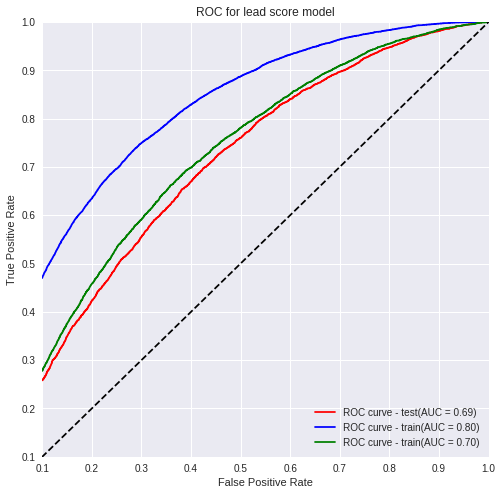

In [156]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

#### Distribution of predicted values

In [157]:
y_pred = gbm.predict(dtest)

In [158]:
print (y_pred.max(), y_pred.min(), y_pred.mean())

0.758609 0.00539377 0.138716


#### Feature importance

In [177]:
importance = gbm.get_fscore()

In [192]:
df_importance = pd.DataFrame(list(importance.items()), columns = ['feature', 'fscore'])
# importance为dict格式，feature为keys，要将其转化为feature字段的取值——list(importance.items())

In [193]:
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [194]:
df_importance.sort_values(['fscore'], ascending = False, inplace = True)
df_importance

,feature,fscore
26,dti,0.044360
13,mosinoldrevtlop,0.035633
31,installment,0.035451
19,mosinoldilacct,0.034542
4,annualinc,0.031815
7,emptitle_freq,0.028634
32,revolutil,0.027634
36,bcopentobuy,0.027361
47,earliestcrline_m,0.026998
39,avgcurbal,0.026998


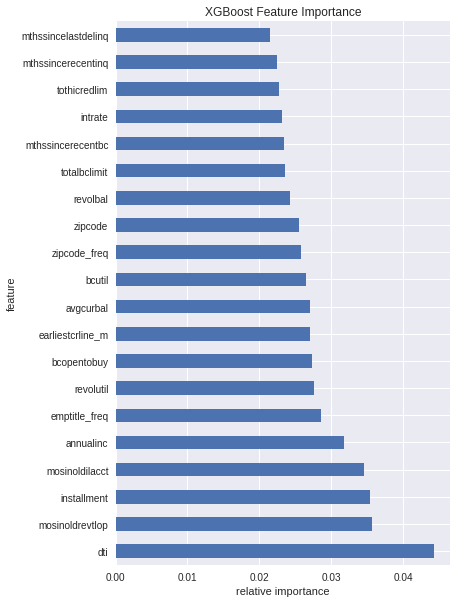

In [195]:
plt.figure(figsize = (32,32))
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend= False, figsize = (6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('../output/feature_importance_xgb.png')

In [198]:
grade_importance = df_importance.query("feature == 'grade'")
grade_importance

,feature,fscore
0,grade,0.003363


In [199]:
subgrade_importance = df_importance.query("feature == 'subgrade'")
subgrade_importance

,feature,fscore
44,subgrade,0.011635


In [200]:
intrate_importance = df_importance.query("feature == 'intrate'")
intrate_importance

,feature,fscore
1,intrate,0.023089


In [202]:
df_importance.query("feature == 'loanamnt'")

,feature,fscore
8,loanamnt,0.018544


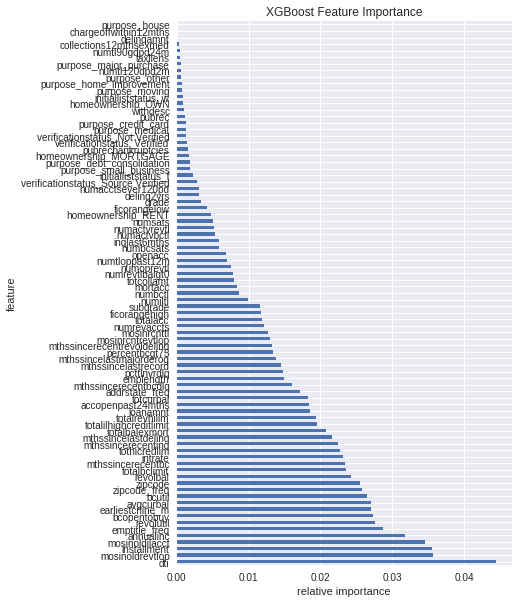

In [203]:
plt.figure(figsize = (32,32))
df_importance.plot(kind = 'barh', x = 'feature', y = 'fscore', legend = False, figsize = (6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

### Save model

In [212]:
import pickle

In [213]:
pickle.dump(gbm, open('../output/model.pkl', "wb"))

In [215]:
from sklearn.externals import joblib
joblib.dump(gbm, "../output/pima.joblib.dat")

['../output/pima.joblib.dat']

In [216]:
with open('../output/model2.pkl', 'wb') as outfile:
    pickle.dump(gbm, outfile)